## 实验6，环境承载量改到65，调整epsilon

### 环境及智能体

- 环境： MinorityGame_1， 少数派游戏，101人博弈，无穷博弈，创建环境时可自定义环境承载量，本实验中固定为65
- 智能体：QLearningAgent，创建智能体时支持自定义学习率、折扣因子以及探索系数，本实验中固定折扣因子和学习率，观察不同探索系数对玩家决策及收益的影响

### 实验结果

101人少数博弈，固定环境承载量为65，学习率为0.1，折扣因子为0.1时，选取不同的探索系数,观察玩家决策和平均收益,发现:

1. 符合实验4，5的结果，折扣因子为0.1时平均回合收益在50上下；
2. 过大的探索系数容易导致玩家偏向随机决策，如果所有智能体完全随机决策（等概率选择0，1）则每回合总收益期望为50.5，本实验中除了探索系数为0.9的智能体外，其他智能体收益表现均不如随机决策，但是探索系数为0.9的智能体（有90%概率随机决策）的平均回合总收益却达到了54；

根据实验4和5，环境承载量改变的情况下折扣因子选择0.1是不靠谱的，因此再进行101人少数博弈，固定环境承载量为65，学习率为0.1，折扣因子为0.9时，选取不同的探索系数,观察玩家决策和平均收益,发现:

1. 折扣因子为0.9时，平均收益会向环境承载量方向移动；
2. 探索系数越低，平均收益稳定越慢，其中探索系数为0.01时需要1000轮才能进入稳定状态，这导致前3000轮平均收益反而没有探索系数0.1时高；
3. 探索系数越低，稳定后平均收益越接近环境承载量；
4. 相比环境承载量为50的情况，平均收益距离最优情况较大，即使将折扣因子设为1，探索系数设为0.01，稳定后回合平均收益在63.4，和最优情况（65）还是有一定差距的。



### 实验内容

#### 实验准备

In [22]:
# MG环境
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
import copy
import math, random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib inline

class MinorityGame_1(gym.Env):
    '''
    Minority Game, we have some agent, every agent can choose 1 or 0 every day.
    In midnight, all of the day to make a few choices of the agent to get +1 reward.
    '''

    def __init__(self, env_max=50):
        '''
        环境初始化:
        玩家数固定101;
        env_max 环境承载量，选择1能获取收益的最大人数，默认为50;
        action_space 动作空间，大小为2，玩家只能选择0或1;
        observation_space 观测空间，这个环境使用2，玩家立足于上一次博弈的状态;
        '''
        self.env_max = env_max
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(2)
        self.seed()


    def seed(self, seed=None):
        '''
        设置seed
        '''
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action_101):
        '''
        每一步博弈：
        1. 检查输入是否合法
        2. 统计选择1的人数allpick，allpick不超过env_max则1获胜，否则0获胜
        3. 返回S(玩家本回合动作), R(所有玩家的奖励列表), done(False，无尽博弈)
        '''
        assert len(action_101) == 101
        assert all(map(lambda x:self.action_space.contains(x), action_101))
        allpick = sum(action_101)
        reward_101 = []
        for action in action_101:
            if action == 1 and allpick <= self.env_max or action == 0 and allpick > self.env_max:
                reward_101.append(1)
            else:
                reward_101.append(0)

        done = True

        return action_101, reward_101, done, {}

    def reset(self):
        '''
        重置环境，每轮第一次博弈给所有玩家一个随机状态
        '''
        # return [0]*101
        return [random.randint(0,1) for _ in range(101)]

# Qlearning智能体
class QLearningAgent:
    '''
    Q-learning智能体实现
    '''

    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.1):
        '''
        Q-learning智能体初始化:
        env 智能体的博弈环境；
        gamma 折扣因子，n步后的奖励为 pow(gamma, n)*Rn, gamma越大表示越重视长期收益。
        learning_rata 学习率，Qlearning 更新过程为:Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)),
                      学习率越大表示越不依赖过去学习的结果
        '''
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        

    def decide(self, state):
        '''
        epsilon-greedy策略，另外Q表所有值相等表示智能体还没有学到任何经验，这时也鼓励探索。
        '''
        if np.random.uniform() > self.epsilon and self.q[state].argmax() != self.q[state].argmin():
            action = self.q[state].argmax()
        else:
            action = 0 if np.random.randint(self.action_n) < 0.5 else 1
        return action
    
    def learn(self, state, action, reward, next_state, done):
        '''
        Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)
        '''
        u = reward + self.gamma * self.q[next_state].max()
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

def play_qlearning(env, agent_101, episodes,render=False):
    '''
    Qlearning智能体一次游戏
    参数:
    env: 游戏环境
    agent_101：101个智能体列表
    episodes: 最大轮数
    render：是否图形显示
    返回值：
    episode_reward
    '''
    episode_rewards = []
    episode_actions = []
    # 初始化S
    observation_101 = env.reset()
    for _ in range(episodes):
        # 各智能体根据环境选择动作
        action_101 = [agent.decide(observation) for agent, observation in zip(agent_101, observation_101)]
        # 执行动作后得到环境奖励和新状态
        next_observation_101, reward_101, done, _ = env.step(action_101)
        # 为所有智能体更新Q表
        for agent, observation, action, reward, next_observation in zip(agent_101, observation_101, action_101, reward_101, next_observation_101):
            agent.learn(observation, action, reward, next_observation,done)
        # 更新状态
        observation = next_observation
        # 上面是Q-learning完整的一步，下面是数据统计
        # 统计动作
        episode_actions.append(action_101)
        # 统计奖励
        episode_rewards.append(reward_101)
    return episode_rewards, episode_actions

def moving_average(lst, N):
    '''
    计算移动平均
    参数:
    lst: 输入列表
    N: 窗口大小
    返回值:
    res: 移动平均列表
    '''
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(sum(lst[l:r])/(r-l))
    return res

def density(lst):
    '''
    将玩家决策原始数据转换成密度数据
    参数:
    lst: 玩家决策原始数据
    返回值:
    res: 玩家决策密度数据
    例:
    输入: [1,1,2,3]
    输出: [0,2,1,1] + [0]*98
    '''
    from collections import Counter
    res = [0] * 102
    tbl = Counter(lst)
    for i in tbl:
        res[i] = tbl[i]/len(lst)
    return res

def variance(lst, N):
    '''
    序列转为方差序列
    参数:
    lst: 输入序列
    N: 计算方差所需元素数
    返回值:
    res: 方差序列
    '''
    import numpy as np
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(np.var(lst[l:r]) if l else 0)
    return res

### 实验过程

1. 基础测试：gamma = 0.1, learning_rate=0.1, epislon=0,1, 博弈3000次，观察玩家收益和动作

玩家总收益


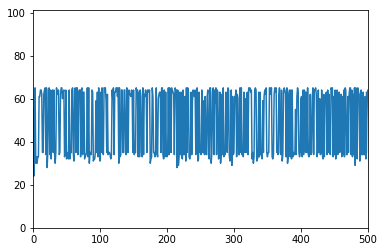

选择1的人数


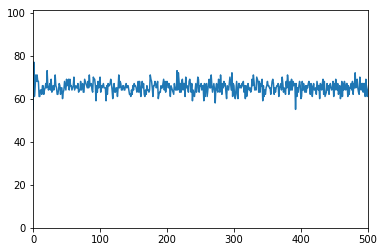

玩家总收益10轮移动平均


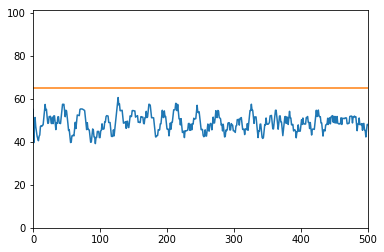

In [23]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.1) for _ in range(101)]

rewards_0, actions_0 = play_qlearning(env,agent_101,3000)

print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_0])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

2. 调整epsilon，观测对结果的影响

玩家总收益


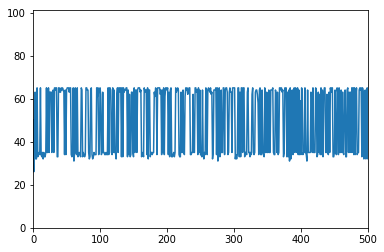

选择1的人数


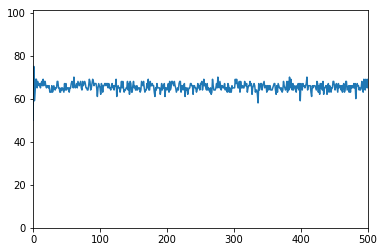

玩家总收益10轮移动平均


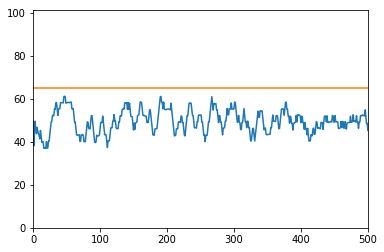

In [24]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.05) for _ in range(101)]
# 博弈
rewards_1a, actions_1a = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1a])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


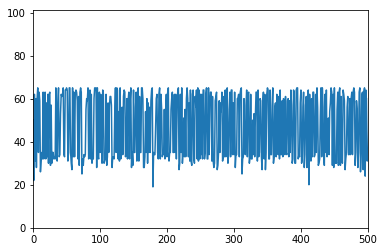

选择1的人数


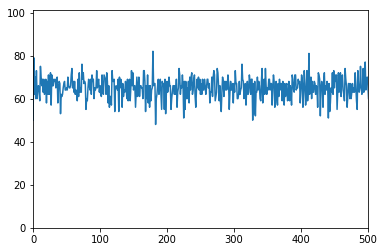

玩家总收益10轮移动平均


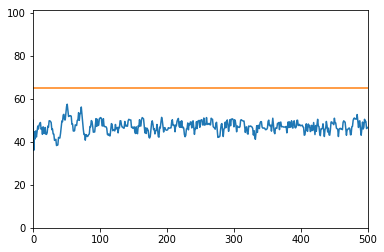

In [25]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.3) for _ in range(101)]
# 博弈
rewards_1b, actions_1b = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1b])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


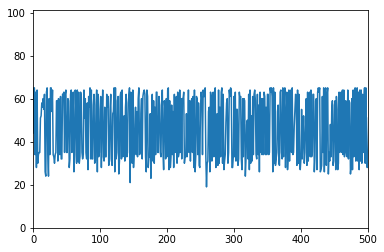

选择1的人数


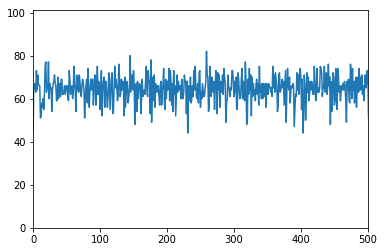

玩家总收益10轮移动平均


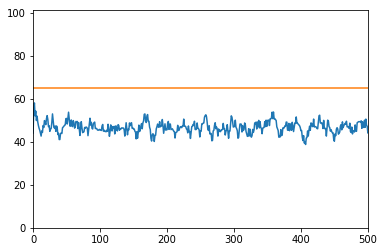

In [26]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.6) for _ in range(101)]
# 博弈
rewards_1c, actions_1c = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1c])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


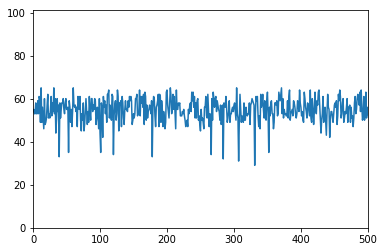

选择1的人数


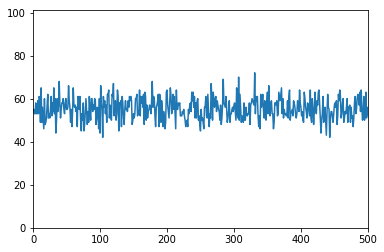

玩家总收益10轮移动平均


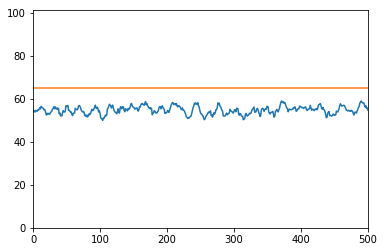

In [27]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.9) for _ in range(101)]
# 博弈
rewards_1d, actions_1d = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1d])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

不同epsilon对平均收益的影响


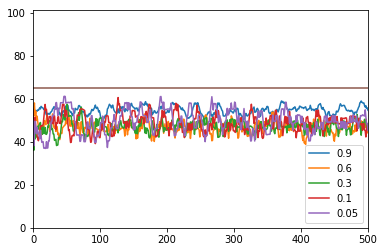

In [28]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对平均收益的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_0],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.legend()
plt.show()

In [29]:
# 因为epsilon过大时玩家更倾向于随机决策，下面加做几组

玩家总收益


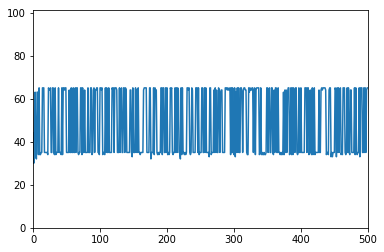

选择1的人数


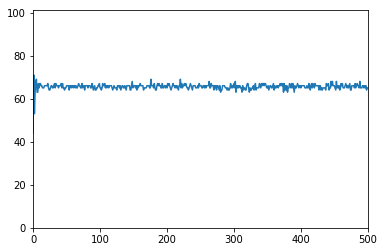

玩家总收益10轮移动平均


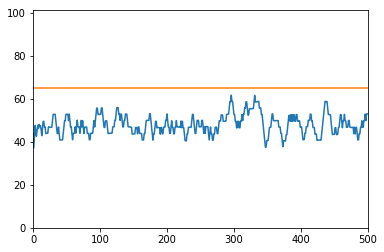

In [30]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.02) for _ in range(101)]
# 博弈
rewards_1e, actions_1e = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1e],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1e])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1e],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


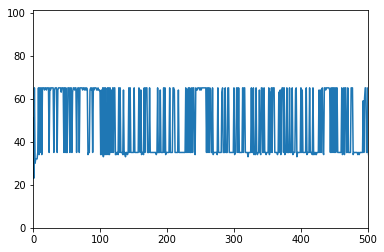

选择1的人数


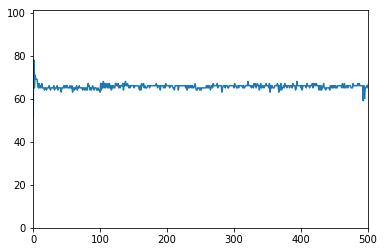

玩家总收益10轮移动平均


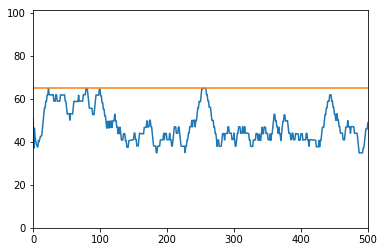

In [31]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.01) for _ in range(101)]
# 博弈
rewards_1f, actions_1f = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1f],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1f])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1f],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


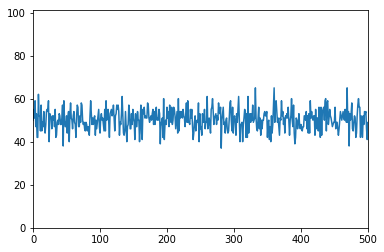

选择1的人数


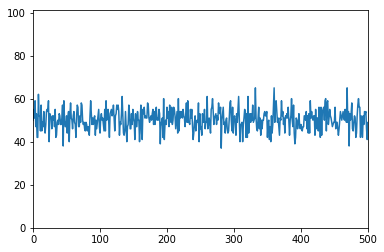

玩家总收益10轮移动平均


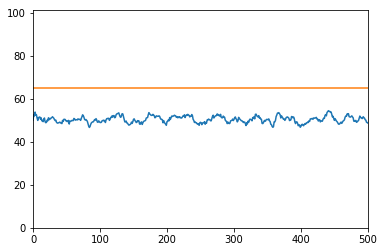

In [32]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=1) for _ in range(101)]
# 博弈
rewards_1h, actions_1h = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1h],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1h])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1h],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

不同epsilon对平均收益的影响


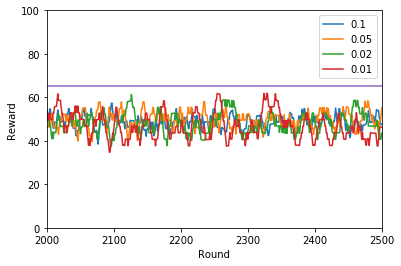

In [52]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
plt.plot(moving_average([sum(reward) for reward in rewards_0],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10),label ='0.05')
plt.plot(moving_average([sum(reward) for reward in rewards_1e],10),label ='0.02')
plt.plot(moving_average([sum(reward) for reward in rewards_1f],10),label ='0.01')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(2000,2500)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


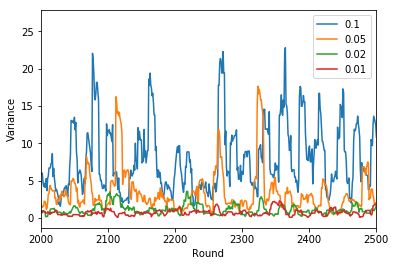

In [54]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Variance")
plt.plot(variance([sum(reward) for reward in actions_0],10),label ='0.1')
# plt.plot(variance([sum(reward) for reward in actions_1c],10),label ='0.6')
plt.plot(variance([sum(reward) for reward in actions_1a],10),label ='0.05')
plt.plot(variance([sum(reward) for reward in actions_1e],10),label ='0.02')
plt.plot(variance([sum(reward) for reward in actions_1f],10),label ='0.01')
plt.xlim(2000,2500)
# plt.axvline(51)
plt.legend()
plt.show()

不同epsilon对决策的影响


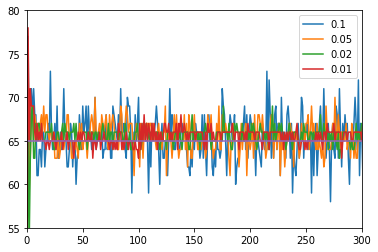

In [34]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对决策的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_0],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_1a],1),label ='0.05')
plt.plot(moving_average([sum(reward) for reward in actions_1e],1),label ='0.02')
plt.plot(moving_average([sum(reward) for reward in actions_1f],1),label ='0.01')
plt.plot([65]*3000)
plt.ylim(55,80)
plt.xlim(0,300)
plt.legend()
plt.show()

In [56]:
print("平均收益对比")
print("  0.01",sum(sum(r) for r in rewards_1f[2000:2500])/len(rewards_1f[2000:2500]))
print("  0.02",sum(sum(r) for r in rewards_1e[2000:2500])/len(rewards_1e[2000:2500]))
print("  0.05",sum(sum(r) for r in rewards_1a[2000:2500])/len(rewards_1a[2000:2500]))
print("   0.1",sum(sum(r) for r in rewards_0[2000:2500])/len(rewards_0[2000:2500]))
print("   0.3",sum(sum(r) for r in rewards_1b[2000:2500])/len(rewards_1b[2000:2500]))
print("   0.6",sum(sum(r) for r in rewards_1c[2000:2500])/len(rewards_1c[2000:2500]))
print("   0.9",sum(sum(r) for r in rewards_1d[2000:2500])/len(rewards_1d[2000:2500]))
print("     1",sum(sum(r) for r in rewards_1h[2000:2500])/len(rewards_1h[2000:2500]))

平均收益对比
  0.01 46.842
  0.02 47.984
  0.05 49.78
   0.1 48.696
   0.3 47.08
   0.6 45.892
   0.9 54.49
     1 50.378


3. 修改折扣因子为0.9，调整epsilon，观测对结果的影响

玩家总收益


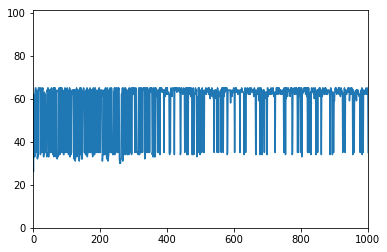

选择1的人数


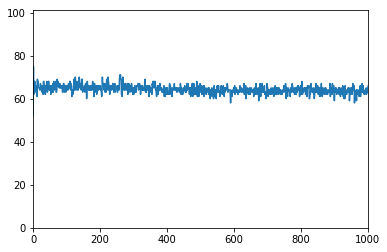

玩家总收益10轮移动平均


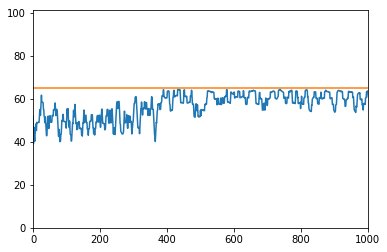

In [36]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.05) for _ in range(101)]
# 博弈
rewards_2a, actions_2a = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2a],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2a])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


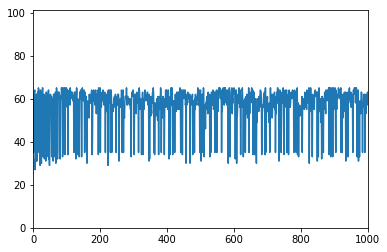

选择1的人数


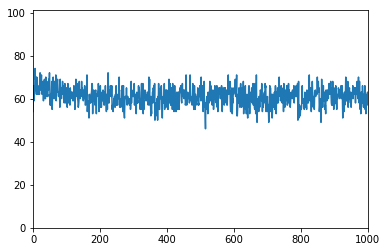

玩家总收益10轮移动平均


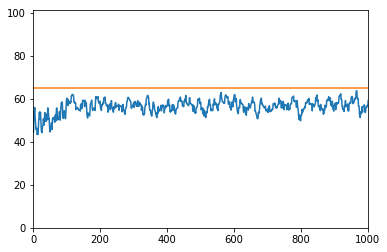

In [37]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.3) for _ in range(101)]
# 博弈
rewards_2b, actions_2b = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2b],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2b])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


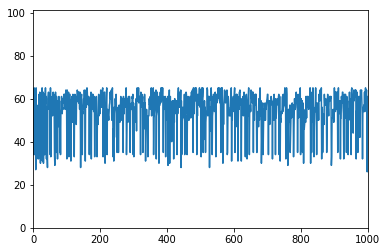

选择1的人数


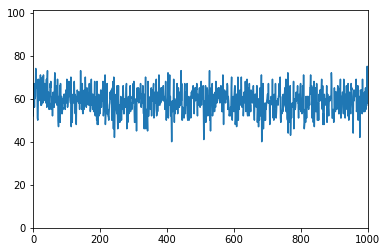

玩家总收益10轮移动平均


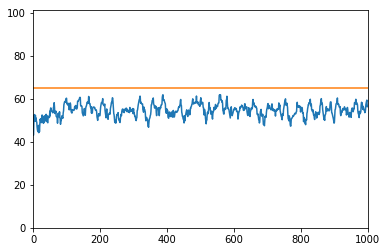

In [38]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.6) for _ in range(101)]
# 博弈
rewards_2c, actions_2c = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2c],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2c])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2c],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


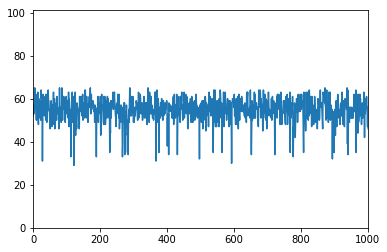

选择1的人数


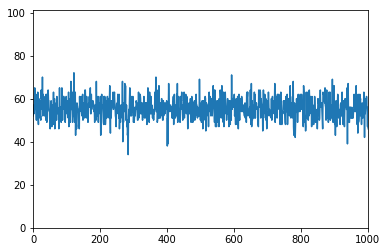

玩家总收益10轮移动平均


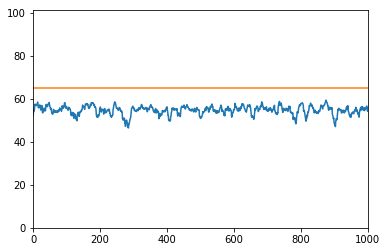

In [39]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.9) for _ in range(101)]
# 博弈
rewards_2d, actions_2d = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2d])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

不同epsilon对平均收益的影响


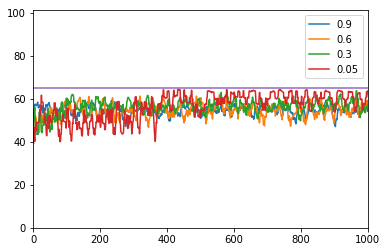

In [40]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对平均收益的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_2c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.legend()
plt.show()

玩家总收益


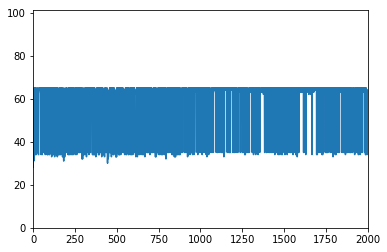

选择1的人数


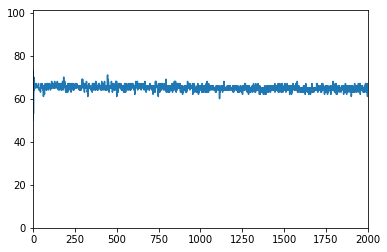

玩家总收益10轮移动平均


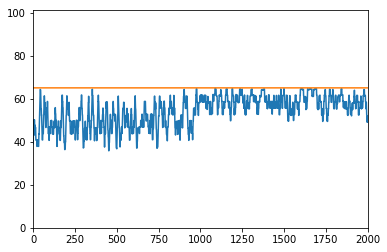

In [41]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.02) for _ in range(101)]
# 博弈
rewards_2e, actions_2e = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前2000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2e],1))
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前2000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2e])
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前2000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2e],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)

玩家总收益


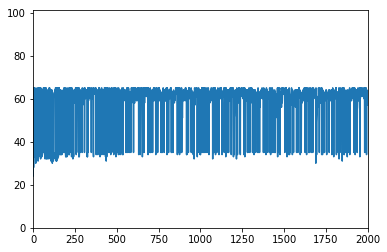

选择1的人数


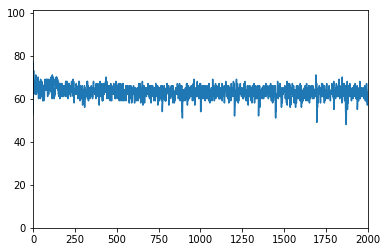

玩家总收益10轮移动平均


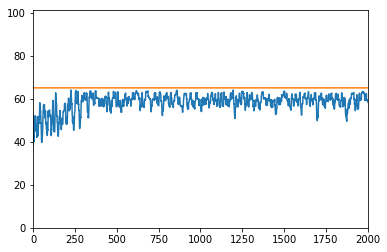

In [42]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2g, actions_2g = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前2000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2g],1))
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前2000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2g])
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前2000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2g],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,2000)
plt.pause(0.1)

玩家总收益


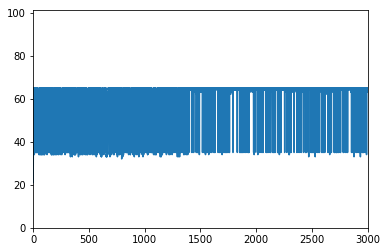

选择1的人数


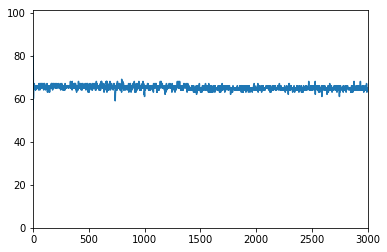

玩家总收益10轮移动平均


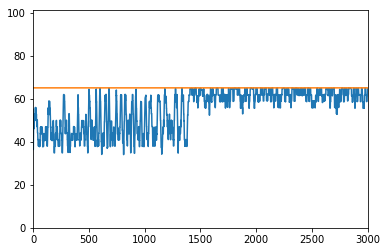

In [43]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.01) for _ in range(101)]
# 博弈
rewards_2f, actions_2f = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2f],1))
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前3000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2f])
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2f],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)

玩家总收益


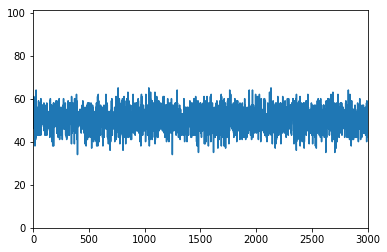

选择1的人数


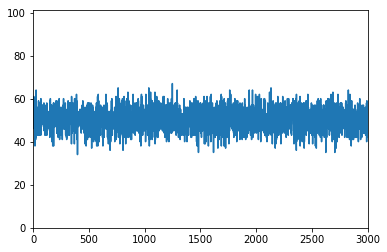

玩家总收益10轮移动平均


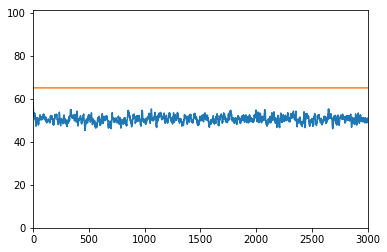

In [44]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=1) for _ in range(101)]
# 博弈
rewards_2h, actions_2h = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2h],1))
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前3000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2h])
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2h],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)

不同epsilon对决策的影响


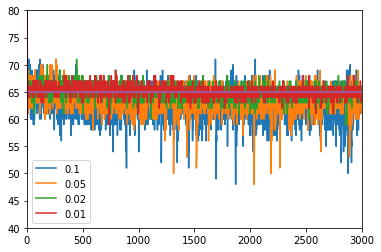

In [73]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对决策的影响")
plt.clf()
# plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in actions_2g],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_2a],1),label ='0.05')
plt.plot(moving_average([sum(reward) for reward in actions_2e],1),label ='0.02')
plt.plot(moving_average([sum(reward) for reward in actions_2f],1),label ='0.01')
plt.plot([65]*3000)
plt.ylim(40,80)
plt.xlim(0,3000)
plt.legend()
plt.show()

不同epsilon对平均收益的影响


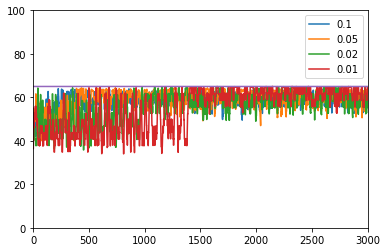

In [57]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对平均收益的影响")
plt.clf()
# plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2g],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.05')
plt.plot(moving_average([sum(reward) for reward in rewards_2e],10),label ='0.02')
plt.plot(moving_average([sum(reward) for reward in rewards_2f],10),label ='0.01')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(0,3000)
plt.legend()
plt.show()

In [47]:
print("平均收益对比(400-500)")
print("  0.01",sum(sum(r) for r in rewards_2f[400:500])/len(rewards_2f[400:500]))
print("  0.02",sum(sum(r) for r in rewards_2e[400:500])/len(rewards_2e[400:500]))
print("  0.05",sum(sum(r) for r in rewards_2a[400:500])/len(rewards_2a[400:500]))
print("   0.1",sum(sum(r) for r in rewards_2g[400:500])/len(rewards_2g[400:500]))
print("   0.3",sum(sum(r) for r in rewards_2b[400:500])/len(rewards_2b[400:500]))
print("   0.6",sum(sum(r) for r in rewards_2c[400:500])/len(rewards_2c[400:500]))
print("   0.9",sum(sum(r) for r in rewards_2d[400:500])/len(rewards_2d[400:500]))
print("     1",sum(sum(r) for r in rewards_2h[400:500])/len(rewards_2h[400:500]))

平均收益对比(400-500)
  0.01 45.87
  0.02 47.6
  0.05 58.44
   0.1 58.22
   0.3 56.94
   0.6 54.95
   0.9 54.13
     1 50.02


In [48]:
print("平均收益对比(1400-1500)")
print("  0.01",sum(sum(r) for r in rewards_2f[1400:1500])/len(rewards_2f[400:500]))
print("  0.02",sum(sum(r) for r in rewards_2e[1400:1500])/len(rewards_2e[400:500]))
print("  0.05",sum(sum(r) for r in rewards_2a[1400:1500])/len(rewards_2a[400:500]))
print("   0.1",sum(sum(r) for r in rewards_2g[1400:1500])/len(rewards_2g[400:500]))
print("   0.3",sum(sum(r) for r in rewards_2b[1400:1500])/len(rewards_2b[400:500]))
print("   0.6",sum(sum(r) for r in rewards_2c[1400:1500])/len(rewards_2c[400:500]))
print("   0.9",sum(sum(r) for r in rewards_2d[1400:1500])/len(rewards_2d[400:500]))
print("     1",sum(sum(r) for r in rewards_2h[1400:1500])/len(rewards_2h[400:500]))

平均收益对比(1400-1500)
  0.01 62.24
  0.02 58.28
  0.05 57.93
   0.1 59.05
   0.3 56.69
   0.6 54.08
   0.9 54.43
     1 50.45


In [84]:
print("平均收益对比(2400-2500)")
print("  0.01",sum(sum(r) for r in rewards_2f[2100:2500])/len(rewards_2f[100:500]))
print("  0.02",sum(sum(r) for r in rewards_2e[2100:2500])/len(rewards_2e[100:500]))
print("  0.05",sum(sum(r) for r in rewards_2a[2100:2500])/len(rewards_2a[100:500]))
print("   0.1",sum(sum(r) for r in rewards_2g[2100:2500])/len(rewards_2g[100:500]))
# print("   0.3",sum(sum(r) for r in rewards_2b[2400:2500])/len(rewards_2b[400:500]))
# print("   0.6",sum(sum(r) for r in rewards_2c[2400:2500])/len(rewards_2c[400:500]))
# print("   0.9",sum(sum(r) for r in rewards_2d[2400:2500])/len(rewards_2d[400:500]))
print("     1",sum(sum(r) for r in rewards_2h[2100:2500])/len(rewards_2h[100:500]))

平均收益对比(2400-2500)
  0.01 61.735
  0.02 59.4775
  0.05 59.465
   0.1 59.0625
     1 50.465


In [87]:
print("决策方差对比(2100-2500)")
print("  0.01",np.var([sum(r) for r in actions_2f[2100:2500]]))
print("  0.02",np.var([sum(r) for r in actions_2e[2100:2500]]))
print("  0.05",np.var([sum(r) for r in actions_2a[2100:2500]]))
print("   0.1",np.var([sum(r) for r in actions_2g[2100:2500]]))
# print("   0.3",sum(sum(r) for r in rewards_2b[2400:2500])/len(rewards_2b[400:500]))
# print("   0.6",sum(sum(r) for r in rewards_2c[2400:2500])/len(rewards_2c[400:500]))
# print("   0.9",sum(sum(r) for r in rewards_2d[2400:2500])/len(rewards_2d[400:500]))
print("     1",np.var([sum(r) for r in actions_2h[2100:2500]]))

决策方差对比(2100-2500)
  0.01 0.43540000000000006
  0.02 1.02324375
  0.05 5.498774999999999
   0.1 6.685974999999998
     1 26.343775000000004


4. 进一步增大折扣因子，测试Qlearning智能体最佳表现

玩家总收益


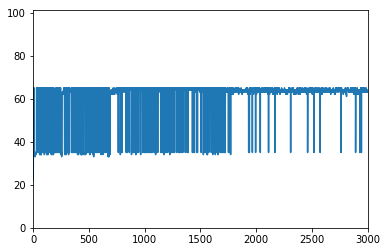

选择1的人数


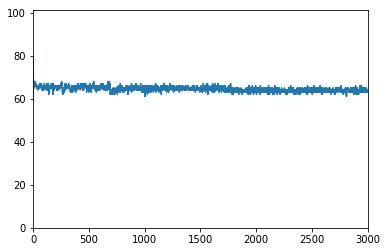

玩家总收益10轮移动平均


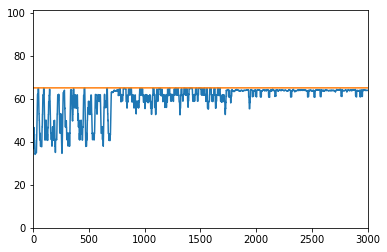

In [48]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=1,learning_rate=0.1,epsilon=0.01) for _ in range(101)]
# 博弈
rewards_3f, actions_3f = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_3f],1))
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前3000轮）
plt.clf()
plt.plot([sum(action) for action in actions_3f])
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前3000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_3f],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.pause(0.1)

In [49]:
print("折扣因子为1，探索系数0.01，稳定后平均收益")
print(sum(sum(r) for r in rewards_3f[1500:])/len(rewards_3f[1500:]))

折扣因子为1，探索系数0.01，稳定后平均收益
63.074


不同epsilon对平均收益的影响


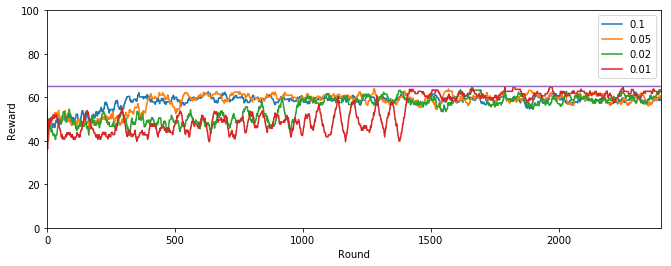

In [72]:
plt.figure(figsize=(11,4))
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
# plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2g],30),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],30),label ='0.05')
plt.plot(moving_average([sum(reward) for reward in rewards_2e],30),label ='0.02')
plt.plot(moving_average([sum(reward) for reward in rewards_2f],30),label ='0.01')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(0,2400)
plt.legend()
plt.show()

不同epsilon对决策的影响


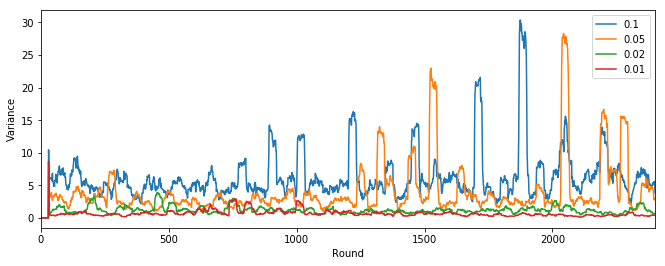

In [83]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同epsilon对决策的影响")
plt.figure(figsize=(11,4))
plt.clf()
plt.xlabel("Round")
plt.ylabel("Variance")
# plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(variance([sum(reward) for reward in actions_2g],30),label ='0.1')
plt.plot(variance([sum(reward) for reward in actions_2a],30),label ='0.05')
plt.plot(variance([sum(reward) for reward in actions_2e],30),label ='0.02')
plt.plot(variance([sum(reward) for reward in actions_2f],30),label ='0.01')
# plt.plot([65]*3000)
# plt.ylim(40,80)
plt.xlim(0,2400)
plt.legend()
plt.show()

In [89]:
a = [sum(r) for r in actions_2f[2100:2500]]

In [93]:
r = [i if i <= 65 else 101-i for i in a]

In [95]:
sum(r)/400

61.735